# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Finite Time Lyapunov Exponent (aFTLE) on 2-D homogeneous, isotropic turbulence. The active LCS diagnostic is applied to the two-dimensional and steady instantaneous linear momentum barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and variables.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Apply active Finite Time Lyapunov Exponent (aFTLE) to instantaneous vorticity barrier equation:

   <br />
    
    For 2D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for vorticity is an autonomous Hamiltonian system of the form:
    
    \begin{equation}
    \mathbf{x}'(s)=\nu \rho \mathbf{J} \nabla \dfrac{D}{Dt}\mathbf{\omega (\mathbf{x}}, t),
    \label{eq: vorticity} 
    \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the aFTLE is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the FTLE, which is fundamentally limited by the temporal domain of the available data.
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \ref{eq: vorticity} by interpolating $ \mathbf{J} \nabla \dfrac{D}{Dt}\mathbf{\omega (\mathbf{x}}, t) $ over the spatial meshgrid.
   
   <br />
   
   * We then apply the aFTLE on the autonomous ODE from equation \ref{eq: vorticity} on different 'dummy' time-intervals. We additionally compare the results with the classic instantaneous FTLE-field.

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0

omega = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1
        
# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

# undersample velocity field as dealing with the full resolution leads to long computational times. 
# Delete the upcoming four lines if you want complete resolution
# U = U[::4, ::4, :]
# V = V[::4, ::4, :]
# X = X[::4, ::4]
# Y = Y[::4, ::4]

CPU times: user 35.7 s, sys: 2.07 s, total: 37.8 s
Wall time: 37.8 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 8

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

In [4]:
# specify time at which to compute instantaneous momentum barriers (this should an integer in [0, 249])
t0 = 0

# specify domain over which to compute linear momentum barriers
x_domain = np.linspace(4.2, 5, 200)
y_domain = np.linspace(2.2, 3, 200)

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# define dummy time interval
ds = 0.001 
tN = 0.25 # Feel free to change this parameter as needed
s_dummy = np.arange(0, tN+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant_u = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 2.4 s, sys: 74 ms, total: 2.47 s
Wall time: 2.47 s


# Instantaneous vorticity barriers

We visualize vorticity barriers by applying the FTLE diagnostic on the trajectories of system \ref{eq: vorticity}. As soon as the FTLE is applied to an active vector field, such as vorticity, we refer to it as aFTLE (active FTLE). We will subsequently compare the results with the classic version of the instantaneous FTLE-field which is given by the maximum eigenvalue of the rate of strain tensor.

In [6]:
%%time
# Import interpolation function for instantaneous active momentum barrier equation
from ipynb.fs.defs.InstantaneousActiveVorticity import InstantaneousActiveVorticity

# Interpolate RHS of vorticity barrier equation using cubic spline interpolation
Interpolant_vorticity = InstantaneousActiveVorticity(t0, X, Y, Interpolant_u, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)

  0%|          | 0/256 [00:00<?, ?it/s]

CPU times: user 44.6 s, sys: 554 ms, total: 45.2 s
Wall time: 44.9 s


## Compute active FTLE

We now compute the active FTLE for the instantaneous linear momentum barrier equations. First, we evaluate the active Cauchy-Green strain tensor from the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: linearmoment_2}. Finally, we apply the classic FTLE to the active Cauchy-Green strain tensor.

In [7]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.ActiveGradientFlowMap import ActiveGradientFlowMap

# Import package which computes eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for computing CauchyGreen (CG) strain tensor
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Import package for computing Finite-Time Lyapunov Exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# parallel computation of active FTLE over meshgrid.
def parallel_FTLE(i):
    
    aFTLE_parallel = np.zeros((X_domain.shape[1], 3))*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])%(2*np.pi)
    
        # compute active gradient of flow map from finite differencing using auxiliary grid
        activegradFmap = ActiveGradientFlowMap(s_dummy, x, Interpolant_vorticity, aux_grid)
        
        # activegradFmap has shape (2, 2, len(s_dummy)) --> we need gradient of flow map from [0, 0.15] and from [0, 0.05]
        
        # activegradFmap from [0, 0.05]
        activegradFmap_t0_t1 = activegradFmap[:,:,50]
        
        # activegradFmap from [0, 0.15]
        activegradFmap_t0_t2 = activegradFmap[:,:,150]
        
        # activegradFmap from [0, 0.25]
        activegradFmap_t0_t3 = activegradFmap[:,:,-1]
        
        # compute active CG from [0, 0.05]
        C1 = CauchyGreen(activegradFmap_t0_t1)
            
        # compute FTLE from CG
        aFTLE_parallel[j, 0] = _FTLE(C1, s_dummy[50])
        
        # compute active CG from [0, 0.15]
        C2 = CauchyGreen(activegradFmap_t0_t2)
        
        # compute FTLE from CG
        aFTLE_parallel[j, 1] = _FTLE(C2, s_dummy[150])
        
        # compute active CG from [0, 0.25]
        C3 = CauchyGreen(activegradFmap_t0_t3)
        
        # compute FTLE from CG
        aFTLE_parallel[j, 2] = _FTLE(C3, s_dummy[-1])

    return aFTLE_parallel

aFTLE = np.array(Parallel(n_jobs=Ncores, verbose = 0, backend = "threading")(delayed(parallel_FTLE)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 9min 11s, sys: 6min 25s, total: 15min 36s
Wall time: 10min 3s


## Compute instantaneous (classic) FTLE-field

The instananeous (classic) FTLE-field at time 't' is given by the maximum eigenvalue of the rate of strain tensor. The rate of strain tensor is computed from the gradient of the velocity field at time 't':

\begin{equation}
\mathbf{S}(\mathbf{x}, t) = \dfrac{1}{2}(\mathbf{\nabla v}(\mathbf{x}, t)+\mathbf{\nabla v}(\mathbf{x}, t)^T)
\end{equation}

### Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [8]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant_u = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 2.15 s, sys: 55.2 ms, total: 2.2 s
Wall time: 2.2 s


### Maximum eigenvalue of rate of strain tensor 

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. $ (\mathbf{x}, t) $ is computed from the gradient of the velocity field by using an auxiliary meshgrid.

In [9]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package which computes eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import Rate of Strain function
from ipynb.fs.defs.RateStrain import RateStrain

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

def parallel_max_eig(i):
    
    lambda_max_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(lambda_max_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # Compute gradient of velocity
        grad_vel = gradient_velocity(t0, x, X, Y, Interpolant_u, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
            
        # Compute eigenvalue of rate of strain at 'x'
        lambda_max_parallel[j] = eigen(RateStrain(grad_vel))[1]
    
    return lambda_max_parallel

FTLE = np.array(Parallel(n_jobs=Ncores, verbose = 0, backend = "threading")(delayed(parallel_max_eig)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2.2 s, sys: 717 ms, total: 2.92 s
Wall time: 2.38 s


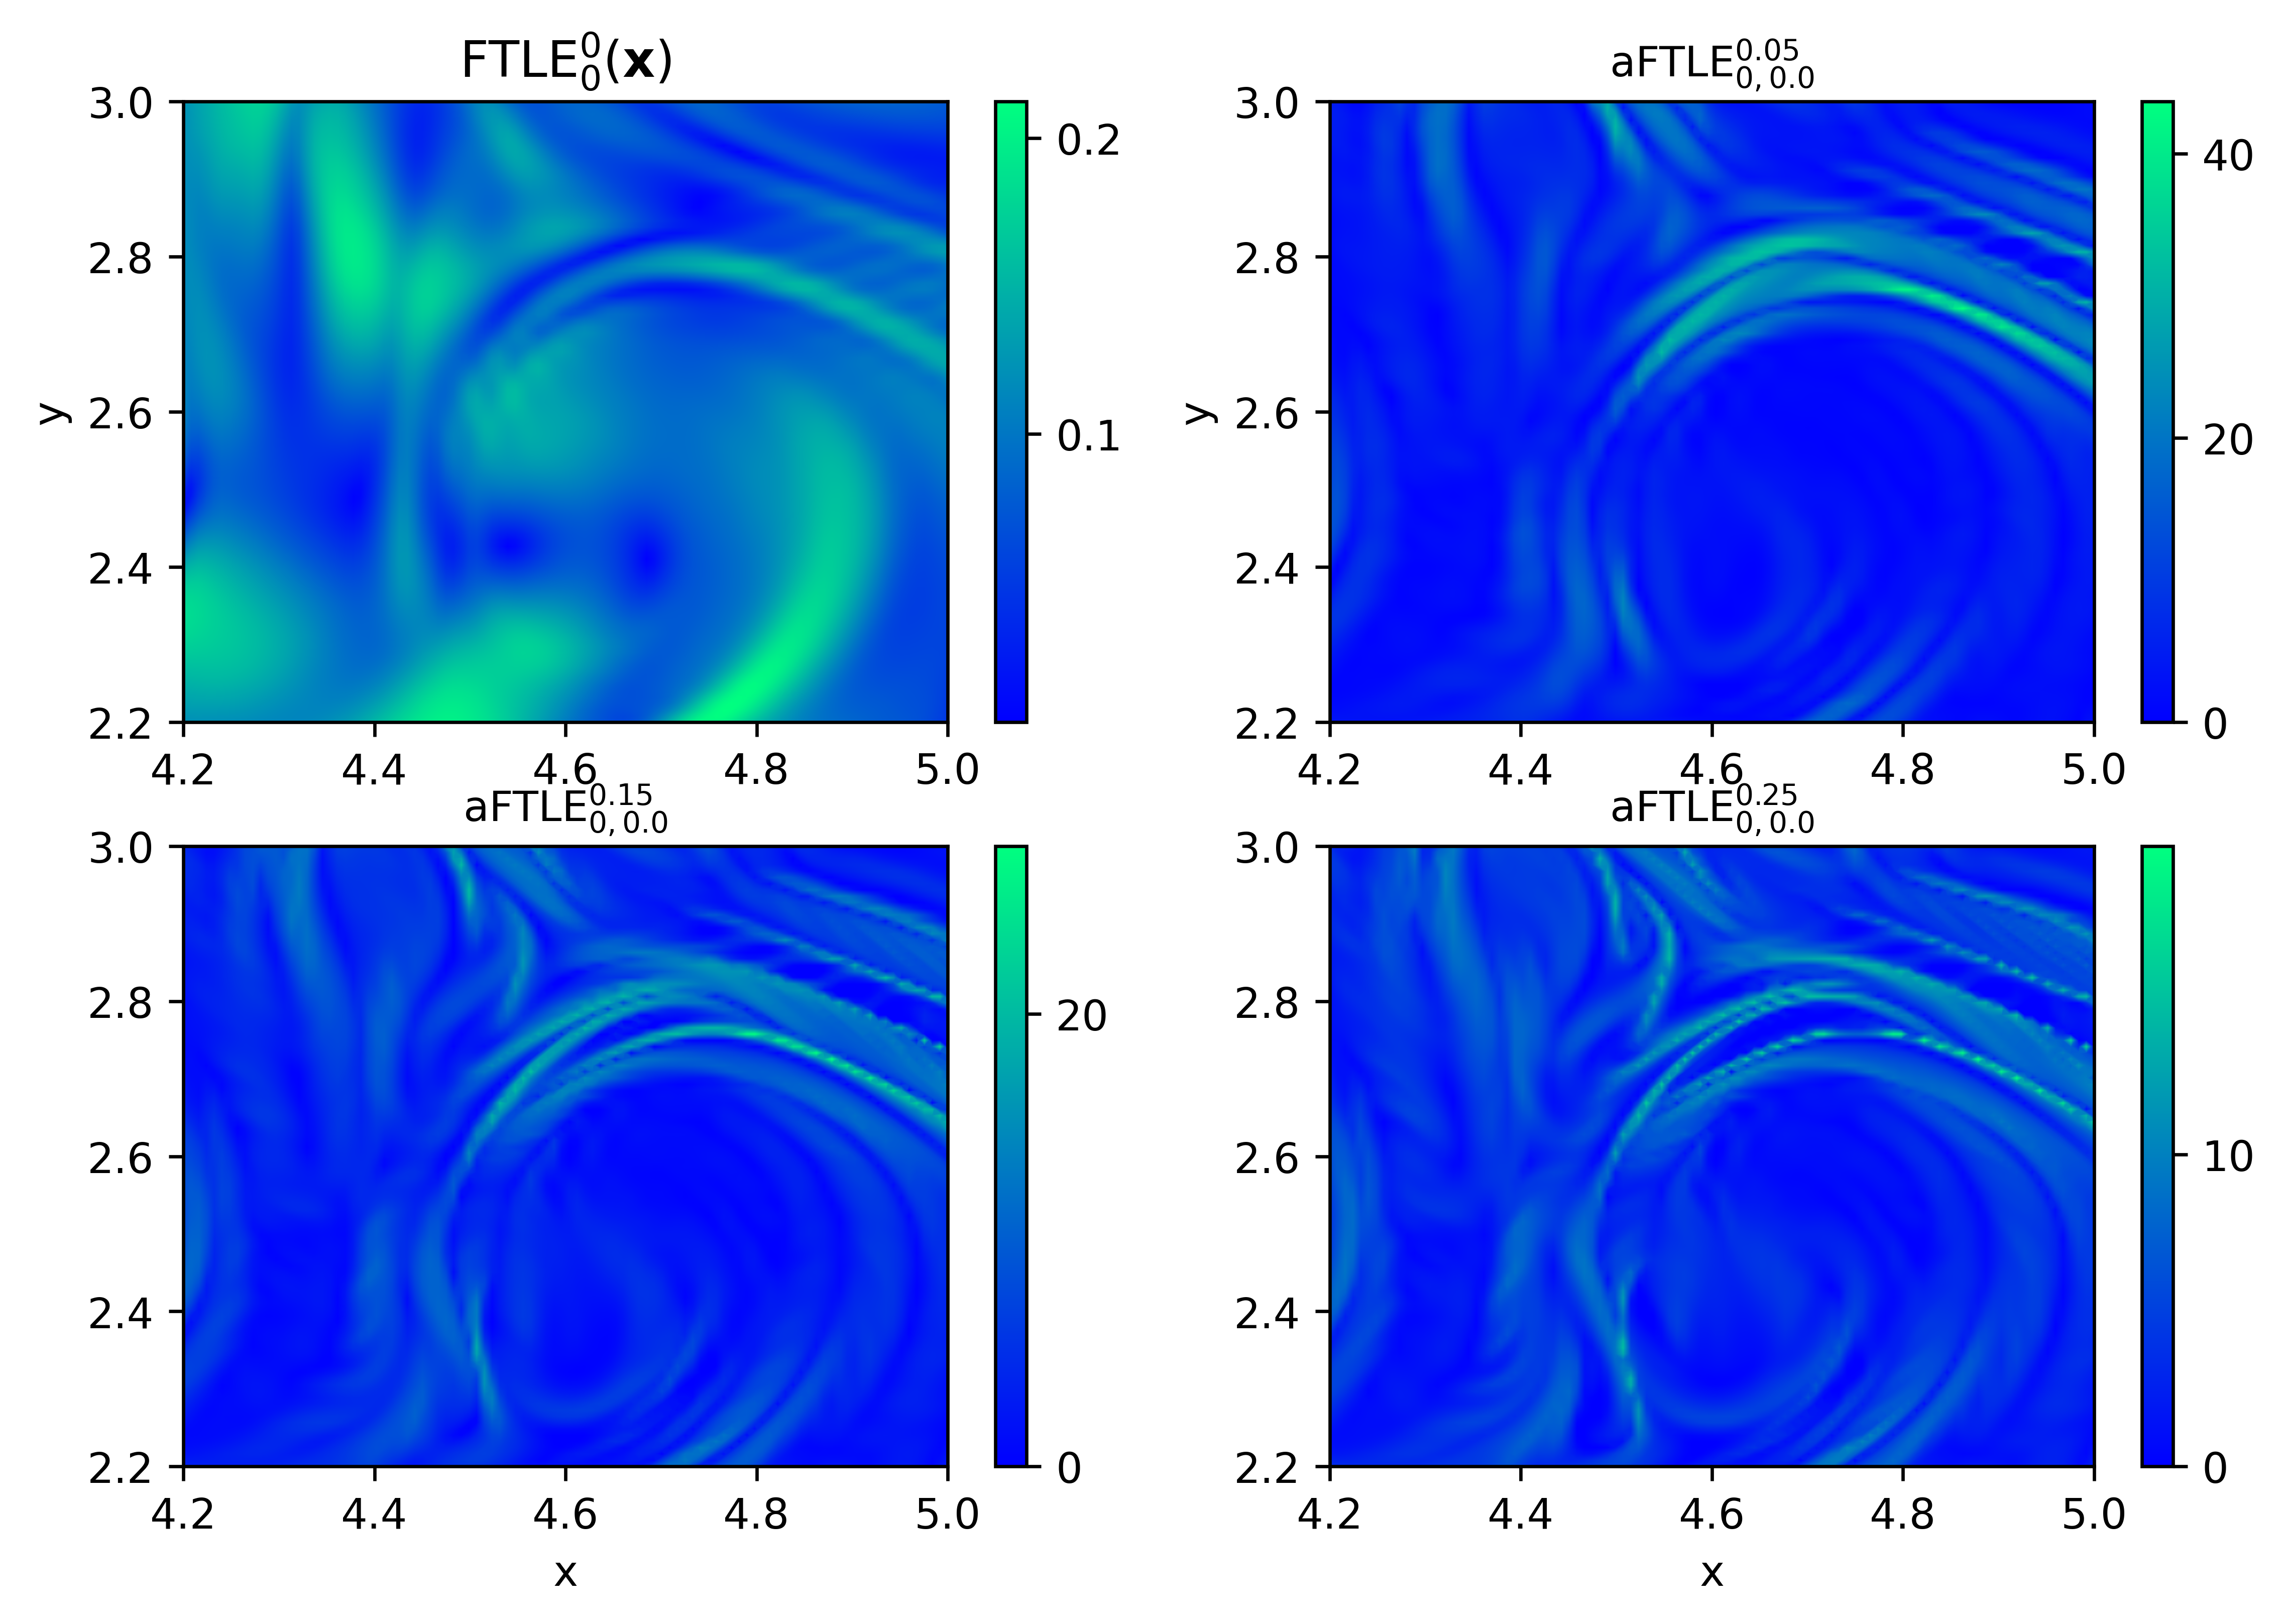

In [22]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(9, 6))

# Contourplot of instantaneous classic FTLE at time 't=0' over meshgrid of initial conditions
cax = ax0.contourf(X_domain, Y_domain, FTLE, cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 0.4, 5))

# Contourplot of aFTLE_0^0.05 over meshgrid of initial conditions
cax = ax1.contourf(X_domain, Y_domain, aFTLE[:,:,0], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 100, 6))

# Contourplot of aFTLE_0^0.15 over meshgrid of initial conditions
cax = ax2.contourf(X_domain, Y_domain, aFTLE[:,:,1], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 100, 6))

# Contourplot of aFTLE_0^0.25 over meshgrid of initial conditions
cax = ax3.contourf(X_domain, Y_domain, aFTLE[:,:,2], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax3, ticks = np.linspace(0, 50, 6))

# Axis Labels
ax2.set_xlabel("x", fontsize = 10)
ax3.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)
ax1.set_ylabel("y", fontsize = 10)

ax0.set_title(r'$\mathrm{FTLE}_{0}^{0}(\mathbf{x})$')
ax1.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[50], 2)}}}$', fontsize = 10)
ax2.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[150], 2)}}}$', fontsize = 10)
ax3.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[-1], 2)}}}$', fontsize = 10)

plt.show()